In [1]:
import torch
import string,re
import torchtext
import numpy as np
import pandas as pd
from collections import OrderedDict

In [2]:
MAX_WORDS=10000
MAX_LEN=200
BATCH_SIZE=20
train_data_path = './data/imdb/train.tsv'
test_data_path = './data/imdb/test.tsv'
train_token_path = './data/imdb/train_token.tsv'
test_token_path =  './data/imdb/test_token.tsv'
train_samples_path = './data/imdb/train_samples/'
test_samples_path =  './data/imdb/test_samples/'

In [3]:
word_count_dict = {}

#清洗文本
def clean_text(text):
    lowercase = text.lower().replace("\n"," ")
    stripped_html = re.sub('<br />', ' ',lowercase)
    cleaned_punctuation = re.sub('[%s]'%re.escape(string.punctuation),'',stripped_html)
    return cleaned_punctuation

with open(train_data_path,"r",encoding = 'utf-8') as f:
    for line in f:
        label,text = line.split("\t")
        cleaned_text = clean_text(text)
        for word in cleaned_text.split(" "):
            word_count_dict[word] = word_count_dict.get(word,0)+1 

In [4]:
df_word_dict = pd.DataFrame(pd.Series(word_count_dict,name = "count"))
df_word_dict = df_word_dict.sort_values(by = "count",ascending =False)

df_word_dict = df_word_dict[0:MAX_WORDS-2] #  
df_word_dict["word_id"] = range(2,MAX_WORDS) #编号0和1分别留给未知词<unkown>和填充<padding>

word_id_dict = df_word_dict["word_id"].to_dict()

df_word_dict.head(10)

,count,word_id
the,268230,2
and,129713,3
a,129479,4
of,116497,5
to,108296,6
is,85615,7
,84074,8
in,74715,9
it,62587,10
i,60837,11


In [5]:
def pad(data_list,pad_length):
    padded_list = data_list.copy()
    if len(data_list)> pad_length:
         padded_list = data_list[-pad_length:]
    if len(data_list)< pad_length:
         padded_list = [1]*(pad_length-len(data_list))+data_list
    return padded_list

def text_to_token(text_file,token_file):
    with open(text_file,"r",encoding = 'utf-8') as fin,\
      open(token_file,"w",encoding = 'utf-8') as fout:
        for line in fin:
            label,text = line.split("\t")
            cleaned_text = clean_text(text)
            word_token_list = [word_id_dict.get(word, 0) for word in cleaned_text.split(" ")]
            pad_list = pad(word_token_list,MAX_LEN)
            out_line = label+"\t"+" ".join([str(x) for x in pad_list])
            fout.write(out_line+"\n")
        
text_to_token(train_data_path,train_token_path)
text_to_token(test_data_path,test_token_path)

In [6]:
import os

if not os.path.exists(train_samples_path):
    os.mkdir(train_samples_path)
    
if not os.path.exists(test_samples_path):
    os.mkdir(test_samples_path)
    
    
def split_samples(token_path,samples_dir):
    with open(token_path,"r",encoding = 'utf-8') as fin:
        i = 0
        for line in fin:
            with open(samples_dir+"%d.txt"%i,"w",encoding = "utf-8") as fout:
                fout.write(line)
            i = i+1

split_samples(train_token_path,train_samples_path)
split_samples(test_token_path,test_samples_path)
print(os.listdir(train_samples_path)[0:100])

['0.txt', '1.txt', '10.txt', '100.txt', '1000.txt', '10000.txt', '10001.txt', '10002.txt', '10003.txt', '10004.txt', '10005.txt', '10006.txt', '10007.txt', '10008.txt', '10009.txt', '1001.txt', '10010.txt', '10011.txt', '10012.txt', '10013.txt', '10014.txt', '10015.txt', '10016.txt', '10017.txt', '10018.txt', '10019.txt', '1002.txt', '10020.txt', '10021.txt', '10022.txt', '10023.txt', '10024.txt', '10025.txt', '10026.txt', '10027.txt', '10028.txt', '10029.txt', '1003.txt', '10030.txt', '10031.txt', '10032.txt', '10033.txt', '10034.txt', '10035.txt', '10036.txt', '10037.txt', '10038.txt', '10039.txt', '1004.txt', '10040.txt', '10041.txt', '10042.txt', '10043.txt', '10044.txt', '10045.txt', '10046.txt', '10047.txt', '10048.txt', '10049.txt', '1005.txt', '10050.txt', '10051.txt', '10052.txt', '10053.txt', '10054.txt', '10055.txt', '10056.txt', '10057.txt', '10058.txt', '10059.txt', '1006.txt', '10060.txt', '10061.txt', '10062.txt', '10063.txt', '10064.txt', '10065.txt', '10066.txt', '1006

In [12]:
import os
from torch.utils.data import Dataset,DataLoader 
class imdbDataset(Dataset):
    def __init__(self,samples_dir):
        self.samples_dir = samples_dir
        self.samples_paths = os.listdir(samples_dir)
    
    def __len__(self):
        return len(self.samples_paths)
    
    def __getitem__(self,index):
        path = self.samples_dir + self.samples_paths[index]
        with open(path,"r",encoding = "utf-8") as f:
            line = f.readline()
            label,tokens = line.split("\t")
            label = torch.tensor([float(label)],dtype = torch.float)
            feature = torch.tensor([int(x) for x in tokens.split(" ")],dtype = torch.long)
            return  (feature,label)
ds_train = imdbDataset(train_samples_path)
ds_test = imdbDataset(test_samples_path)

print(len(ds_train))
print(len(ds_test))

dl_train = DataLoader(ds_train,batch_size = BATCH_SIZE,shuffle = True,num_workers=0)
dl_test = DataLoader(ds_test,batch_size = BATCH_SIZE,num_workers=0)

20000
5000


In [13]:
for features,labels in dl_train:
    print(features)
    print(labels)
    break

tensor([[   1,    1,    1,  ...,   39,   12,    8],
        [   1,    1,    1,  ...,   32, 2085,    8],
        [   1,    1,    1,  ...,    4,   63,    8],
        ...,
        [   1,    1,    1,  ...,  119,  123,    8],
        [   1,    1,    1,  ...,  245,    8,    8],
        [  53,  111,    3,  ...,    7,    0,    8]])
tensor([[1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])


In [14]:
import torch
from torch import nn 
import torchkeras

In [15]:
torch.random.seed()
import torch
from torch import nn 

class Net(torchkeras.Model):
    
    def __init__(self):
        super(Net, self).__init__()
        
        #设置padding_idx参数后将在训练过程中将填充的token始终赋值为0向量
        self.embedding = nn.Embedding(num_embeddings = MAX_WORDS,embedding_dim = 3,padding_idx = 1)
        self.conv = nn.Sequential()
        self.conv.add_module("conv_1",nn.Conv1d(in_channels = 3,out_channels = 16,kernel_size = 5))
        self.conv.add_module("pool_1",nn.MaxPool1d(kernel_size = 2))
        self.conv.add_module("relu_1",nn.ReLU())
        self.conv.add_module("conv_2",nn.Conv1d(in_channels = 16,out_channels = 128,kernel_size = 2))
        self.conv.add_module("pool_2",nn.MaxPool1d(kernel_size = 2))
        self.conv.add_module("relu_2",nn.ReLU())
        
        self.dense = nn.Sequential()
        self.dense.add_module("flatten",nn.Flatten())
        self.dense.add_module("linear",nn.Linear(6144,1))
        self.dense.add_module("sigmoid",nn.Sigmoid())
        
    def forward(self,x):
        x = self.embedding(x).transpose(1,2)
        x = self.conv(x)
        y = self.dense(x)
        return y
        

model = Net()
print(model)

model.summary(input_shape = (200,),input_dtype = torch.LongTensor)

Net(
  (embedding): Embedding(10000, 3, padding_idx=1)
  (conv): Sequential(
    (conv_1): Conv1d(3, 16, kernel_size=(5,), stride=(1,))
    (pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_1): ReLU()
    (conv_2): Conv1d(16, 128, kernel_size=(2,), stride=(1,))
    (pool_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_2): ReLU()
  )
  (dense): Sequential(
    (flatten): Flatten()
    (linear): Linear(in_features=6144, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1               [-1, 200, 3]          30,000
            Conv1d-2              [-1, 16, 196]             256
         MaxPool1d-3               [-1, 16, 98]               0
              ReLU-4               [-1, 16, 98]               0
            Conv1d-5              [-1, 128, 97]  

In [16]:
def accuracy(y_pred,y_true):
    y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred,dtype = torch.float32),
                      torch.zeros_like(y_pred,dtype = torch.float32))
    acc = torch.mean(1-torch.abs(y_true-y_pred))
    return acc

model.compile(loss_func = nn.BCELoss(),optimizer= torch.optim.Adagrad(model.parameters(),lr = 0.02),
             metrics_dict={"accuracy":accuracy})

In [17]:
dfhistory = model.fit(20,dl_train,dl_val=dl_test,log_step_freq= 200)

Start Training ...

================================================================================2020-09-23 15:42:47
{'step': 200, 'loss': 0.72, 'accuracy': 0.518}
{'step': 400, 'loss': 0.706, 'accuracy': 0.516}
{'step': 600, 'loss': 0.7, 'accuracy': 0.525}
{'step': 800, 'loss': 0.696, 'accuracy': 0.534}
{'step': 1000, 'loss': 0.69, 'accuracy': 0.546}

 +-------+------+----------+----------+--------------+
| epoch | loss | accuracy | val_loss | val_accuracy |
+-------+------+----------+----------+--------------+
|   1   | 0.69 |  0.546   |  0.666   |    0.589     |
+-------+------+----------+----------+--------------+

================================================================================2020-09-23 15:43:42
{'step': 200, 'loss': 0.656, 'accuracy': 0.616}
{'step': 400, 'loss': 0.645, 'accuracy': 0.625}
{'step': 600, 'loss': 0.638, 'accuracy': 0.633}
{'step': 800, 'loss': 0.632, 'accuracy': 0.639}
{'step': 1000, 'loss': 0.624, 'accuracy': 0.649}

 +-------+-------+----------

{'step': 400, 'loss': 0.253, 'accuracy': 0.9}
{'step': 600, 'loss': 0.261, 'accuracy': 0.895}
{'step': 800, 'loss': 0.262, 'accuracy': 0.895}
{'step': 1000, 'loss': 0.264, 'accuracy': 0.893}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   14  | 0.264 |  0.893   |  0.485   |    0.787     |
+-------+-------+----------+----------+--------------+

================================================================================2020-09-23 15:56:05
{'step': 200, 'loss': 0.245, 'accuracy': 0.904}
{'step': 400, 'loss': 0.246, 'accuracy': 0.9}
{'step': 600, 'loss': 0.248, 'accuracy': 0.899}
{'step': 800, 'loss': 0.249, 'accuracy': 0.9}
{'step': 1000, 'loss': 0.251, 'accuracy': 0.899}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   15  | 0.251 |  0.899   

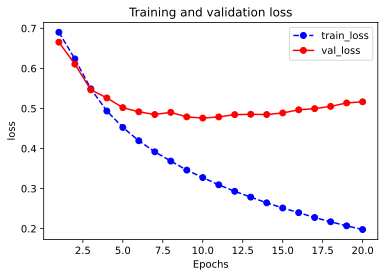

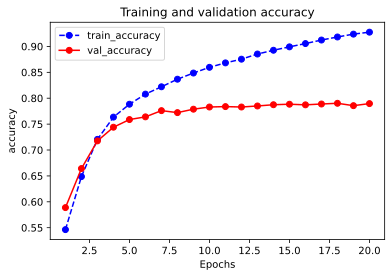

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(dfhistory,"loss")
plot_metric(dfhistory,"accuracy")

In [19]:
model.evaluate(dl_test)

{'val_loss': 0.5166334499120713, 'val_accuracy': 0.7896000020503998}

In [20]:
model.predict(dl_test)

tensor([[0.3325],
        [0.9935],
        [0.9745],
        ...,
        [0.9926],
        [0.5546],
        [0.4139]])

In [21]:
print(model.state_dict().keys())

odict_keys(['embedding.weight', 'conv.conv_1.weight', 'conv.conv_1.bias', 'conv.conv_2.weight', 'conv.conv_2.bias', 'dense.linear.weight', 'dense.linear.bias'])


In [22]:
torch.save(model.state_dict(), "./data/model_parameter.pkl")

model_clone = Net()
model_clone.load_state_dict(torch.load("./data/model_parameter.pkl"))

model_clone.compile(loss_func = nn.BCELoss(),optimizer= torch.optim.Adagrad(model.parameters(),lr = 0.02),
             metrics_dict={"accuracy":accuracy})

# 评估模型
model_clone.evaluate(dl_test)

{'val_loss': 0.5166334499120713, 'val_accuracy': 0.7896000020503998}

In [ ]:
tokenizer=lambda x:re.sub('[%s]'%string.punctuation,"",x).split(" ")

In [ ]:
def filterLowFreqWords(arr,vocab):
    arr=[[x if x<MAX_WORDS else 0 for x in example]
         for example in arr ]
    return arr

In [ ]:
TEXT=torchtext.data.Field(sequential=True,tokenize=tokenizer,lower=True,fix_length=MAX_LEN,postprocessing=filterLowFreqWords)

In [ ]:
LABEL=torchtext.data.Field(sequential=False,use_vocab=False)

In [ ]:
ds_train,ds_test=torchtext.data.TabularDataset.splits(
    path='./data/imdb', train='train.tsv',test='test.tsv',format='tsv',
    fields=[('label', LABEL), ('text',TEXT)],skip_header=False
)

In [ ]:
TEXT.build_vocab(ds_train)

In [ ]:
train_iter=torchtext.data.Iterator.splits(
    ds_train, sort_within_batch=True, sort_key=lambda x:len(x.text), 
    batch_size=BATCH_SIZE
)

In [ ]:
print(ds_train[0].text)
print(ds_train[0].label)

In [ ]:
print(len(TEXT.vocab))
print(TEXT.vocab.itos[0])
print(TEXT.vocab.itos[1])
print(TEXT.vocab.stoi['<unk>'])
print(TEXT.vocab.stoi['<pad>'])

print(TEXT.vocab.freqs['<unk>'])
print(TEXT.vocab.freqs['a'])
print(TEXT.vocab.freqs['good'])

In [ ]:
for b in train_iter:
    features=b.text
    labels=b.label
    print(features)
    print(features.shape)
    print(labels)
    break